In [25]:
#required libraries
import numpy as np
import pygame           
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import time
import random
from collections import deque
import matplotlib.pyplot as plt

In [26]:
# global constants

SCREEN_WIDTH, SCREEN_HEIGHT = 1280, 720
BG_COLOR = (120, 120, 120)
DRAW_COLOR = (50, 50, 50)

DRAW_RADIUS = 2
ERASE_RADIUS = 5  

CAR_WIDTH, CAR_HEIGHT = 20, 40
DEFAULT_START_X, DEFAULT_START_Y = 892, 426
DEFAULT_START_ANGLE = -45
DEFAULT_START_SPEED = 0
ACCELERATION = 0.05
BRAKE_FORCE = 0.1
MAX_SPEED = 5.00
FRICTION = 0.025
MIN_TURN_ANGLE = 1.5
MAX_TURN_ANGLE = 2

TRACK_SAVE_PATH = "monza_draw.png"
CAR_IMAGE_PATH = "Track_images/car.png"
TRACK_IMAGE_PATH = r"Track_images\track1.png"

finish_line_rect=pygame.Rect(DEFAULT_START_X+30,DEFAULT_START_Y-20,10,100)
checkpoint_data=[
    (834,520,10,120,0),
    (600,540,10,120,0),
    (110,569,10,120,90),
    (285,483,10,120,0),
    (366,314,10,120,0),
    (355,173,10,120,0),
    (450,109,10,120,0),
    (606,170,10,120,0),
    (818,91,10,120,0),
    (1127,88,10,120,310),
    (1094,270,10,120,0),
    (920,346,10,120,45)
]

FOR making th track drawing 
left ckick for drawing the track
right click for eraing the track

In [27]:
def draw_track():
    """
    Function to draw the racing track.
    Left mouse button to draw, right mouse button to erase.
    Press 'S' to save the track as an image.
    """
    pygame.init()
    pygame.display.set_caption("Drawing the track, press 'S' to save as image.")
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    screen.fill(BG_COLOR)
    running, drawing, erase = True, False, False
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    drawing = True
                elif event.button == 3:
                    erase = True
            elif event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    drawing = False
                elif event.button == 3:
                    erase = False
            elif event.type == pygame.MOUSEMOTION:
                mouse_pos = pygame.mouse.get_pos()
                if drawing:
                    pygame.draw.circle(screen, DRAW_COLOR, mouse_pos, DRAW_RADIUS)
                elif erase:
                    pygame.draw.circle(screen, BG_COLOR, mouse_pos, ERASE_RADIUS)
            elif event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                pygame.image.save(screen, TRACK_SAVE_PATH)
        pygame.display.update()
    pygame.quit()

In [28]:
class Car:
    """
    Class representing a car in the racing simulation.
    """
    def __init__(self, image_path, x, y, angle=0, speed=0):
        self.original_image = pygame.transform.scale(
            pygame.image.load(image_path).convert_alpha(), 
            (CAR_WIDTH, CAR_HEIGHT)
        )
        image = pygame.image.load(image_path).convert_alpha()
        self.image = pygame.transform.scale(image, (CAR_WIDTH, CAR_HEIGHT))
        self.x, self.y = x, y
        self.angle = angle
        self.speed = speed
        self.rect=self.image.get_rect(center=(self.x,self.y))
        self.mask=pygame.mask.from_surface(self.image)

    def move(self):
        rad = np.radians(self.angle)
        self.x += self.speed * np.cos(rad)
        self.y -= self.speed * np.sin(rad)
        self.rect.center = (self.x, self.y)

    def draw(self, screen):
        self.image = pygame.transform.rotate(self.original_image, self.angle)
        self.rect = self.image.get_rect(center=(self.x, self.y))
        self.mask = pygame.mask.from_surface(self.image)
        screen.blit(self.image, self.rect.topleft)
        
    def get_rect(self):
        return self.rect

In [29]:
def ray_casting(car, track_surface):
    """Cast rays from the car's position to detect the track boundaries.

    Args:
        car (class): The car object.
        track_surface (Surface): The surface of the track.

    Returns:
        sensor_distance (float): The distance to the nearest track boundary.
        sensor_endpoint (tuple): The (x, y) coordinates of the sensor endpoint.
    """
    sensor_distance = []
    sensor_endpoint = []
    sensor_angle = [-45, 0, 45]

    for angle in sensor_angle:
        ray_angle = car.angle + angle
        ray_x, ray_y = car.x, car.y
        distance = 0
        max_distance = 200

        while distance < max_distance:
            rad = np.radians(ray_angle)
            ray_x += np.cos(rad)
            ray_y -= np.sin(rad)
            distance += 1

            if not (0 <= ray_x < SCREEN_WIDTH and 0 <= ray_y < SCREEN_HEIGHT):
                break

            pixel_color = track_surface.get_at((int(ray_x), int(ray_y)))[0:3]
            if pixel_color == DRAW_COLOR:
                break

        sensor_distance.append(distance)
        sensor_endpoint.append((ray_x, ray_y))

    return sensor_distance, sensor_endpoint

In [ ]:
def model():
    """Builds a simple feedforward neural network model.

    Returns:
        model: A Keras Sequential model instance.
    """
    model=Sequential(
        [Dense(32,activation='relu',input_shape=(3,)),
         Dense(16,activation='relu'),
         Dense(4,activation='linear')]
    )
    model.compile(optimizer='adam',loss='mse')
    return model
ai_model=model()
ai_model.summary()
    

c:\Users\Yash\OneDrive\Desktop\Neural Networks Car Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724 (2.83 KB)

 Trainable params: 724 (2.83 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
class DQNAgent:
    """
    A Deep Q-Network (DQN) agent for reinforcement learning.
    Attributes:
        model: The neural network model used for approximating Q-values.
        memory: A deque to store past experiences for experience replay.
        gamma: Discount factor for future rewards.
        epsilon: Exploration rate for the epsilon-greedy policy.
        epsilon_min: Minimum exploration rate.
        epsilon_decay: Decay rate for exploration after each training episode.
        batch_size: Size of the minibatch for training.
    Methods:
        remember: Store an experience in memory.
        choose_action: Select an action based on the current state using an epsilon-greedy policy.
        train_from_memory: Train the model using a minibatch of experiences from memory.
    """
    def __init__(self, model):
        self.model = model
        self.memory = deque(maxlen=20000) # Increased memory size for better learning
        self.gamma = 0.95  # Discount factor: how much to value future rewards
        self.epsilon = 1.0  # Exploration rate: initial probability of taking a random action
        self.epsilon_min = 0.01 # Minimum exploration rate
        self.epsilon_decay = 0.999 # Decay rate for exploration
        self.batch_size = 32 # Increased batch size for more stable training

    def remember(self, state, action, reward, next_state, done):
        """Stores an experience tuple in the agent's memory."""
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        """
        Selects an action based on the current state using an epsilon-greedy policy.
        With probability epsilon, it takes a random action (exploration).
        Otherwise, it takes the best known action (exploitation).
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(4)  # Return a random action (0, 1, 2, or 3)
        
        # Predict Q-values for the given state and choose the action with the highest Q-value
        q_values = self.model.predict(np.reshape(state, [1, 3]), verbose=0)
        return np.argmax(q_values[0])

    def train_from_memory(self):
        """Train the DQN agent using experiences from memory.

        Returns:
            float: The training loss.
        """
        if len(self.memory) < self.batch_size:
            return None # Return None if not training

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([experience[0] for experience in minibatch])
        actions = np.array([experience[1] for experience in minibatch])
        rewards = np.array([experience[2] for experience in minibatch])
        next_states = np.array([experience[3] for experience in minibatch])
        dones = np.array([experience[4] for experience in minibatch])

        current_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)

        targets = rewards + self.gamma * np.amax(next_q_values, axis=1) * (1 - dones)
        
        for i, action in enumerate(actions):
            current_q_values[i][action] = targets[i]

        # FIX: Capture the history object to get the loss
        history = self.model.fit(states, current_q_values, epochs=1, verbose=0)
        loss = history.history['loss'][0]

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

In [32]:
def model_game_step(action, car, track_image, current_checkpoint):
    """
    Simulates a game step for the car in the racing environment.

    Args:
        action (int): Action to be taken by the car (0: left, 1: straight, 2: right, 3: brake).
        car (Car): The car object representing the player's car.
        track_image (Surface): The image of the track.
        current_checkpoint (int): The index of the current checkpoint.

    Returns:
        tuple: A tuple containing the new state, done flag, reward, and current checkpoint.
    """
    done = False
    
    # --- NEW MULTI-COMPONENT REWARD SYSTEM ---

    # 1. Base reward: A small penalty for each step taken. 
    # This encourages the agent to finish the lap faster.
    reward = -0.1

    # 2. Reward for Speed: Encourage the car to move forward, not stand still.
    # The reward is proportional to its speed.
    reward += car.speed * 0.2

    # 3. Reward for Progress: This is the most important part.
    # We get the sensor readings (the state) and reward the agent
    # for having a clear path ahead. The middle sensor (state[1]) looks forward.
    current_state, _ = ray_casting(car, track_image)
    # The farther the wall, the higher the reward.
    reward += current_state[1] * 0.005 

    # 4. Penalty for Sharp Turns: Discourage frantic wiggling.
    # Encourage smoother driving by penalizing turning actions slightly.
    if action == 0 or action == 2: # Actions for left/right turns
        reward -= 0.2

    # --- CAR PHYSICS (No changes here) ---
    car.speed += ACCELERATION
    if car.speed > 0:
        speed_factor = car.speed / MAX_SPEED
        dynamic_turn_angle = MAX_TURN_ANGLE - (speed_factor) * (MAX_TURN_ANGLE - MIN_TURN_ANGLE)
        if action == 0:  # Left
            car.angle += dynamic_turn_angle
        elif action == 2:  # Right
            car.angle -= dynamic_turn_angle
    
    if action == 3: # Brake
        car.speed -= BRAKE_FORCE
    
    car.speed -= FRICTION
    car.speed = max(0, min(car.speed, MAX_SPEED))
    car.move()
    
    # --- GOAL-BASED REWARDS (Checkpoints and Crashing) ---
    checkpoint_rects = [pygame.Rect(x, y, w, h) for x, y, w, h, a in checkpoint_data]
    
    # 5. Large reward for hitting a checkpoint.
    if current_checkpoint < len(checkpoint_rects):
        if car.rect.colliderect(checkpoint_rects[current_checkpoint]):
            current_checkpoint += 1
            reward += 30 # Large positive reward
            print(f"Checkpoint {current_checkpoint} reached!")

    # 6. Very large reward for finishing the lap.
    if current_checkpoint == len(checkpoint_rects) and car.rect.colliderect(finish_line_rect):
        reward += 300
        current_checkpoint = 0
        print("Lap finished!")

    # 7. Large penalty for crashing.
    try:
        pixel_color = track_image.get_at((int(car.x), int(car.y)))[:3]
        if pixel_color == BG_COLOR:
            done = True
    except IndexError:
        done = True
        
    if done:
        reward = -20 # Keep a significant penalty for crashing, but not as extreme as -100

    new_state, _ = ray_casting(car, track_image)
    return new_state, done, reward, current_checkpoint

In [33]:
def train_dqn(episodes=500):
    """
    Main function to train the DQN agent and visualize the results.
    """
    pygame.init()
    # ... (rest of your Pygame setup) ...
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    track_surface = pygame.image.load(TRACK_IMAGE_PATH).convert()
    
    ai_model = model()
    agent = DQNAgent(ai_model)

    # FIX: Add lists to store history for plotting
    scores_history = []
    loss_history = []
    
    for e in range(episodes):
        car = Car(CAR_IMAGE_PATH, DEFAULT_START_X, DEFAULT_START_Y, DEFAULT_START_ANGLE, DEFAULT_START_SPEED)
        current_checkpoint = 0
        state, _ = ray_casting(car, track_surface)
        state = np.reshape(state, [1, 3])
        
        total_reward = 0
        max_steps_per_episode = 2000

        for step in range(max_steps_per_episode):
            action = agent.choose_action(state)
            next_state, done, reward, new_checkpoint = model_game_step(action, car, track_surface, current_checkpoint)
            
            total_reward += reward
            next_state = np.reshape(next_state, [1, 3])
            current_checkpoint = new_checkpoint
            
            agent.remember(state[0], action, reward, next_state[0], done)
            state = next_state
            
            # FIX: Move training inside the step loop and capture loss
            loss = agent.train_from_memory()
            if loss is not None:
                loss_history.append(loss)

            if done:
                break
        
        scores_history.append(total_reward)
        print(f"Episode: {e+1}/{episodes}, Score: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

        if (e + 1) % 50 == 0:
            ai_model.save_weights(f"dqn_car_weights_episode_{e+1}.weights.h5")

    pygame.quit()

    # --- Plotting the results after training ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot Score vs. Episode
    ax1.plot(scores_history, label='Score per Episode', color='royalblue')
    ax1.set_title('Agent Score Over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend()

    # Plot Loss vs. Training Step
    ax2.plot(loss_history, label='Training Loss', color='orangered', alpha=0.7)
    ax2.set_title('Model Loss Over Time')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('MSE Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [34]:
def run_ai_simulation():
    """Runs the car simulation controlled by an AI model.
        The AI model predicts actions based on the car's sensor data.
        0: turn left
        1: accelerate
        2: turn right
        3: brake
    """
    pygame.init()
    screen=pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    clock=pygame.time.Clock()
    pygame.display.set_caption("AI Car Simulation")
    track_surface=pygame.image.load(TRACK_IMAGE_PATH).convert()
    car=Car(CAR_IMAGE_PATH,DEFAULT_START_X,DEFAULT_START_Y,DEFAULT_START_ANGLE,DEFAULT_START_SPEED)
    font=pygame.font.SysFont(None,22)
    
    running=True
    while running:
        for event in pygame.event.get():
            if event.type==pygame.QUIT:
                running=False
        current_state,ray_endpoints=ray_casting(car,track_surface)
        reshaped_state = np.reshape(current_state, [1, 3])
        q_values = ai_model.predict(reshaped_state, verbose=0)
        action = np.argmax(q_values[0])
        _ ,_ ,done=model_game_step(action,car,track_surface)
        if done:
            text_surface = font.render("Car Crashed! Resetting...", True, (255, 255, 255))
            screen.blit(text_surface, (50, 50))
            pygame.display.update()
            pygame.time.wait(1000)
            car=Car(CAR_IMAGE_PATH,DEFAULT_START_X,DEFAULT_START_Y,DEFAULT_START_ANGLE,DEFAULT_START_SPEED)
        
        screen.blit(track_surface,(0,0))
        car.draw(screen)
        
        text_surface = font.render(f"Distances: {current_state}", True, (255, 255, 255))
        screen.blit(text_surface, (50, 80))
        for points in ray_endpoints:
            pygame.draw.line(screen,(0,255,0),(car.x,car.y),points,1)
            
        pygame.display.update()
        clock.tick(60)
    pygame.quit()
        

In [35]:
def run_simulation(
    start_x=DEFAULT_START_X,
    start_y=DEFAULT_START_Y,
    start_angle=DEFAULT_START_ANGLE,
    start_speed=DEFAULT_START_SPEED
):
    """Runs the car simulation manually by the user.

    Args:
        start_x (int, optional): The starting x-coordinate of the car. Defaults to DEFAULT_START_X.
        start_y (int, optional): The starting y-coordinate of the car. Defaults to DEFAULT_START_Y.
        start_angle (float, optional): The starting angle of the car. Defaults to DEFAULT_START_ANGLE.
        start_speed (float, optional): The starting speed of the car. Defaults to DEFAULT_START_SPEED.
    """
    pygame.init()
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    clock = pygame.time.Clock()
    pygame.display.set_caption("Car Simulation")

    track_image = pygame.image.load(TRACK_IMAGE_PATH).convert()
    track_surface = track_image.copy()

    car = Car(CAR_IMAGE_PATH, start_x, start_y, start_angle, start_speed)

    screen.fill(BG_COLOR)
    screen.blit(track_image, (0, 0))

    CAR_ROAD_COLOR = track_surface.get_at((start_x, start_y))[:3]

  

    lap_start_time=0
    best_lap_time=float('inf')
    current_lap_time=0
    lap_started=False
    car_on_finish=False

    car_max_speed = 0
    
    #checkpoints
    checkpoints=[]
    
    for x,y,w,h,a in checkpoint_data:
        base_surface=pygame.Surface((w,h),pygame.SRCALPHA)
        base_surface.fill((255,0,255,100))
        rotated_surface=pygame.transform.rotate(base_surface,a)
        rect=rotated_surface.get_rect(center=(x,y))
        mask=pygame.mask.from_surface(rotated_surface)
        checkpoints.append({'surface': rotated_surface, 'rect': rect, 'mask': mask})
    current_checkpoint=0

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        keys = pygame.key.get_pressed()
        if car.speed > 0:
            car.speed -= FRICTION
        if car.speed < 0:
            car.speed += FRICTION
        if abs(car.speed) < FRICTION:
            car.speed = 0
        if keys[pygame.K_DOWN]:
            car.speed -= BRAKE_FORCE
        if keys[pygame.K_UP]:
            if car.speed < MAX_SPEED:
                car.speed += ACCELERATION
                
        if car.speed > 0.1:
            speed_factor = car.speed / MAX_SPEED
            turn_range = MAX_TURN_ANGLE - MIN_TURN_ANGLE
            dynamic_turn_angle = MAX_TURN_ANGLE - (speed_factor * turn_range)
        
            if keys[pygame.K_LEFT]:
                car.angle += dynamic_turn_angle
            if keys[pygame.K_RIGHT]:
                car.angle -= dynamic_turn_angle

        screen.blit(track_image, (0, 0))

        font = pygame.font.Font(None, 22)
        text_surface = font.render(f"Speed: {car.speed:.2f}", True, (255, 255, 255))
        screen.blit(text_surface, (50, 50))

        # Ray casting
        distance, sensor_endpoint = ray_casting(car, track_surface)
        text_surface = font.render(f"Distances: {distance}", True, (255, 255, 255))
        screen.blit(text_surface, (50, 80))
        for endpoint in sensor_endpoint:
            pygame.draw.line(screen, (0, 255, 0), (car.x, car.y), endpoint, 1)

        car.move()
        
        #cheking checkpoints
        if current_checkpoint < len(checkpoints):
            target = checkpoints[current_checkpoint]

            # compute offset of target mask relative to car mask
            offset_x = target['rect'].left - car.rect.left
            offset_y = target['rect'].top  - car.rect.top


            if (offset_y==0 and -60<offset_x<60) or (offset_x==0 and -60<offset_y<60):
                current_checkpoint += 1
                print(f"Checkpoint reached! {current_checkpoint}")

        
        car.draw(screen)
        
        for i, cp in enumerate(checkpoints):
          screen.blit(cp['surface'], cp['rect'])
          if i == current_checkpoint:
              pygame.draw.rect(screen, (0, 255, 0), cp['rect'], 3)
        
        #lap timing (collision detection)
        is_colliding=car.get_rect().colliderect(finish_line_rect)
        if is_colliding and not car_on_finish:
            car_on_finish=True
            if lap_started and current_checkpoint == len(checkpoints):
                lap_time=time.time()-lap_start_time
                best_lap_time=min(best_lap_time,lap_time)
                lap_start_time=time.time()
                current_checkpoint=0
            elif not lap_started:
                lap_started = True
                lap_start_time = time.time()
                current_checkpoint = 0
        if not is_colliding:
            car_on_finish=False
            
        pygame.draw.rect(screen, (250, 100, 50), finish_line_rect)
        

        # Collision detection (including out-of-bounds)
        crashed = False
        car_center_pos = (int(car.x), int(car.y))
        if not (0 <= car.x < SCREEN_WIDTH and 0 <= car.y < SCREEN_HEIGHT):
            crashed = True
        else:
            try:
                pixel_color = track_surface.get_at(car_center_pos)[:3]
                if pixel_color != CAR_ROAD_COLOR:
                    crashed = True
            except IndexError:
                crashed = True

        if crashed:
            lap_started=False
            current_lap_time=0 
            current_checkpoint=0
            text_surface = font.render("Car has crashed!", True, (255, 255, 255))
            screen.blit(text_surface, (50, 110))
            pygame.display.update()
            pygame.time.wait(1000)  # Show message for 1 second
            car.x, car.y = start_x, start_y
            car.angle = start_angle
            car.speed = start_speed

        if car.speed > car_max_speed:
            car_max_speed = car.speed

        if lap_started:
            current_lap_time = time.time() - lap_start_time
            current_lap_str = f"Lap: {current_lap_time:.2f}s"
        else:
            current_lap_str = "Lap: 0.00s"                                           
        best_lap_str = f"Best: {best_lap_time:.2f}s" if best_lap_time != float('inf') else "Best: N/A"
        text_surface = font.render(current_lap_str, True, (255, 255, 255))            
        screen.blit(text_surface, (50, 500))
        best_text = font.render(best_lap_str, True, (255, 255, 255))
        screen.blit(best_text, (50, 530))
        text_surface = font.render(f"Max speed: {car_max_speed:.2f}", True, (255, 255, 255))
        screen.blit(text_surface, (50, 470))

        pygame.display.update()
        clock.tick(60)

    pygame.quit()

        if event.type == pygame.MOUSEMOTION:
            mouse_point = event.pos
            text_surface = font.render(f"Location: {mouse_point}", True, (255, 255, 255))
            screen.blit(text_surface, (50, 100))
 #code for getting mouse location
 


Episode: 1/300, Score: -20.00, Epsilon: 1.00
Episode: 2/300, Score: -20.00, Epsilon: 1.00
Episode: 3/300, Score: -20.00, Epsilon: 1.00
Episode: 4/300, Score: -20.00, Epsilon: 1.00
Episode: 5/300, Score: -20.00, Epsilon: 1.00
Episode: 6/300, Score: -20.00, Epsilon: 1.00
Episode: 7/300, Score: -20.00, Epsilon: 1.00
Episode: 8/300, Score: -20.00, Epsilon: 1.00
Episode: 9/300, Score: -20.00, Epsilon: 1.00
Episode: 10/300, Score: -20.00, Epsilon: 1.00
Episode: 11/300, Score: -20.00, Epsilon: 1.00
Episode: 12/300, Score: -20.00, Epsilon: 1.00
Episode: 13/300, Score: -20.00, Epsilon: 1.00
Episode: 14/300, Score: -20.00, Epsilon: 1.00
Episode: 15/300, Score: -20.00, Epsilon: 1.00
Episode: 16/300, Score: -20.00, Epsilon: 1.00
Episode: 17/300, Score: -20.00, Epsilon: 1.00
Episode: 18/300, Score: -20.00, Epsilon: 1.00
Episode: 19/300, Score: -20.00, Epsilon: 1.00
Episode: 20/300, Score: -20.00, Epsilon: 1.00
Episode: 21/300, Score: -20.00, Epsilon: 1.00
Episode: 22/300, Score: -20.00, Epsilon: 1.

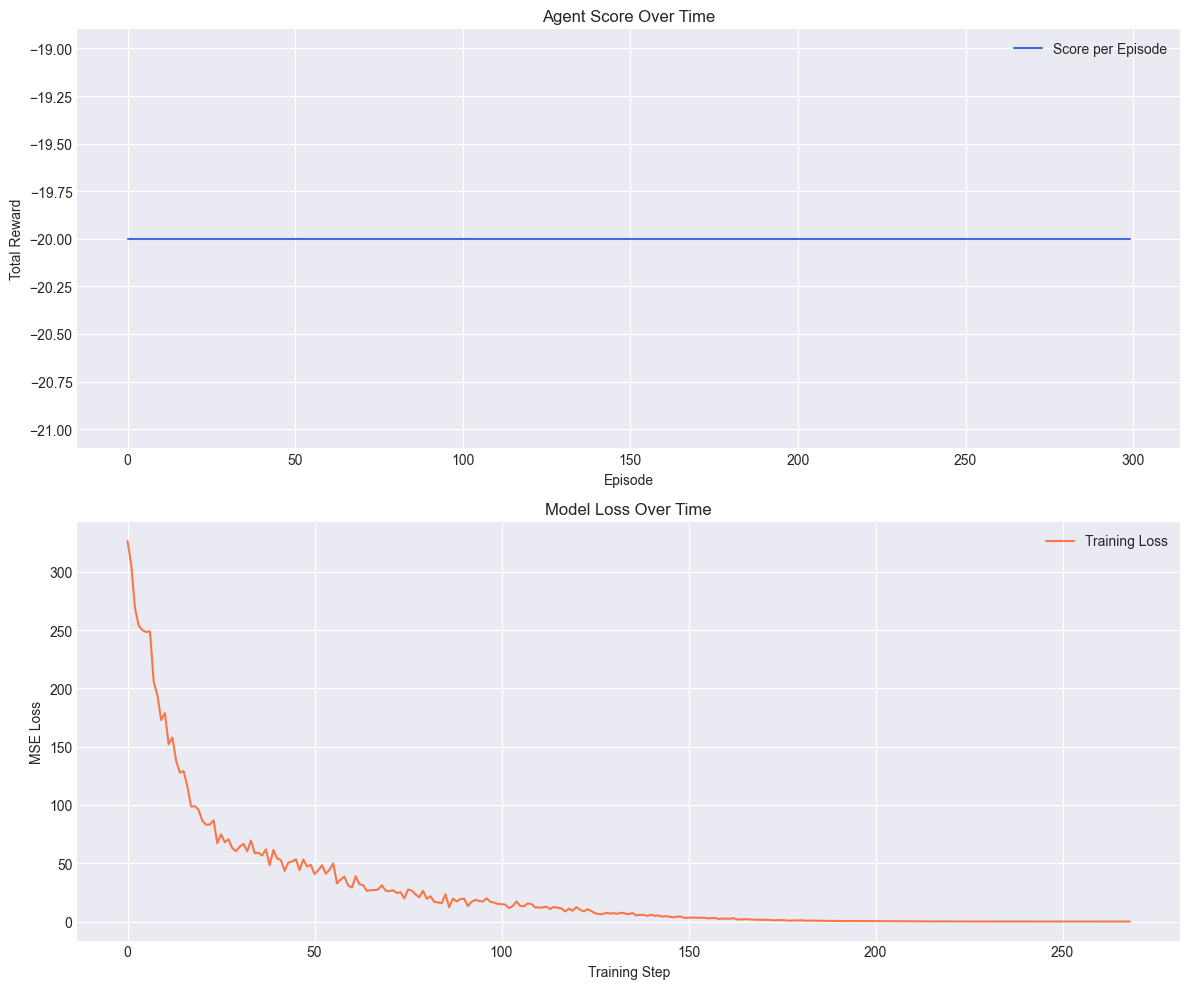

In [36]:
if __name__ == "__main__":
    #draw_track()
    # run_simulation()
    # run_ai_simulation()
    train_dqn(episodes=300)
